# 3. Modelling & Evaluation

## 3.1 Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X = pd.read_csv("/data/X.csv")
y = pd.read_csv("/data/y.csv")
X_2 = pd.read_csv("/data/X_2.csv")
y_2 = pd.read_csv("/data/y_2.csv")
X_3 = pd.read_csv("/data/X_3.csv")
y_3 = pd.read_csv("/data/y_3.csv")

In [ ]:
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.4, random_state = 42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.4, random_state = 42)

In [ ]:
# Dataset with outliers
print("Original dataset :", X.shape, y.shape)
print("Training dataset :", X_train.shape, y_train.shape)
print("Testing dataset  :", X_test.shape,"", y_test.shape)
print("")

#Dataset with outliers removed
print("Original dataset 2 :", X_2.shape, y_2.shape)
print("Training dataset 2 :", X_train_2.shape, y_train_2.shape)
print("Testing dataset  2 :", X_test_2.shape,"", y_test_2.shape)
print("")

#Dataset with outliers floored and capped
print("Original dataset 3 :", X_3.shape, y_3.shape)
print("Training dataset 3 :", X_train_3.shape, y_train_3.shape)
print("Testing dataset  3 :", X_test_3.shape,"", y_test_3.shape)

Original dataset : (6435, 123) (6435, 1)
Training dataset : (3861, 123) (3861, 1)
Testing dataset  : (2574, 123)  (2574, 1)

Original dataset 2 : (6057, 123) (6057, 1)
Training dataset 2 : (3634, 123) (3634, 1)
Testing dataset  2 : (2423, 123)  (2423, 1)

Original dataset 3 : (6435, 123) (6435, 1)
Training dataset 3 : (3861, 123) (3861, 1)
Testing dataset  3 : (2574, 123)  (2574, 1)


## 3.2 Create Function

In [ ]:
# Change font size for ticks
def bigger_ticks_font_size(ax):
    ax.tick_params(axis = "x", labelsize = 13)
    ax.tick_params(axis = "y", labelsize = 13)

# Change font size for labels
def bigger_label_font_size(ax, xlabel_name, ylabel_name):
    ax.set_xlabel(xlabel_name, fontsize = 16)
    ax.set_ylabel(ylabel_name, fontsize = 16)

# Create a new color palette consisted of the extracted hex codes from Set2 palette and other additional colors
palette = ["#fc8d62", "#ffd92f", "#e5c494", "#b3b3b3", "#66c2a5", "#96b9d0", "#8da0cb", "#ce94bc", "#eba7ac", "#f5ae52"]

In [ ]:
# Function to do prediction for each training and testing test
def PredictData (model, X_train, X_test):
    dataset = {"y_train" : model.predict(X_train),  # Prediction with training dataset
               "y_test"  : model.predict(X_test)}   # Prediction with testing dataset
    return dataset

In [ ]:
# Function to evaluate model 
def EvaluateModel (y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    nrmse = rmse/np.std(y_pred)
    r2 = r2_score(y_test, y_pred)
    

    eval_metric = {"MAE" : mae,
                   "MSE" : mse,
                   "RMSE" : rmse,
                   "MAPE" : mape,
                   "NRMSE" : nrmse,
                   "R2_Score": r2}

    return eval_metric

In [ ]:
# Evaluation Metric Comparison for different Regression Models
def PlotMetric (eval_train, eval_test, metric, idx, top_result, model_title, figsize, legend_coor, float_limit):

    fig, ax = plt.subplots(figsize = figsize)
    # Store evaluation result for each training and testing set
    eval_train = eval_train[metric]
    eval_test  = eval_test[metric]

    # If it's R2_Score sort with the highest value first, if not (which means it's error rate) sort with the lowest value first
    ascending_val       = np.where(metric == "R2_Score", False, True)
    eval_train_sorted   = eval_train.sort_values(ascending = bool(ascending_val))
    eval_test_sorted    = eval_test.sort_values(ascending = bool(ascending_val))
    
    # Default value for lineweight, dot size, and fontweight
    lw_train    = np.full((len(eval_train)), 1)
    lw_test     = np.full((len(eval_train)), 1)
    size_train  = np.full((len(eval_train)), 50)
    size_test   = np.full((len(eval_train)), 50)  
    fw_train    = ["normal"]*len(eval_train)
    fw_test     = ["normal"]*len(eval_train)

    # Make linewidth, dot size, and fontweight stand out for 3 top metric scores (lowest error/highest performance)
    for x in range(len(eval_train)):
        for n in range(top_result):
            if(eval_train[x] == eval_train_sorted[n]): #If value is the best score(at n-th index of sorted values)
                lw_train[x] = 3; size_train[x] = 160; fw_train[x] = "semibold"
            if(eval_test[x] == eval_test_sorted[n]):
                lw_test[x] = 3; size_test[x] = 160; fw_test[x] = "semibold"

    # Function to keep the line and dot inside the plot if the score is <0 or >100 
    def FindXCoor(eval_data):
        return np.where(((eval_data.values*100) > 100), 1.03,
               np.where(((eval_data.values*100) < 0), 0, eval_data.values))
    # Store the custom x coordinates for each dataset           
    x_coor_test = FindXCoor(eval_test)
    x_coor_train = FindXCoor(eval_train)    

    # Plot horizontal lines
    plt.hlines(y = np.arange(len(eval_test.index))+0.2, xmin = 0, xmax = x_coor_test, color = palette[0], alpha = 0.5, linewidth = lw_test)
    plt.hlines(y = np.arange(len(eval_train.index))-0.2, xmin = 0, xmax = x_coor_train, color = palette[5], alpha = 0.5, linewidth = lw_train)

    # Plot dots   
    ax.scatter(x = x_coor_test, y = np.arange(len(eval_test.index))+0.2, color = palette[0], s = size_test, alpha = 1, label = "Test Data")
    ax.scatter(x = x_coor_train, y = np.arange(len(eval_test.index))-0.2, color = palette[5], s = size_train, alpha = 1, label = "Training Data")

    # Plot text (percentage)
    for i, v in enumerate(eval_test):
        plt.text(x_coor_test[i] + 0.05, i+0.15, str("{:.{}f}%".format(v*100, float_limit)), color="black", fontsize = 12, fontweight = fw_test[i])
    for i, v in enumerate(eval_train):
        plt.text(x_coor_train[i] +0.05, i-0.25, str("{:.{}f}%".format(v*100, float_limit)), color="black", fontsize = 12, fontweight = fw_train[i])
    
    ax.set_yticks(np.arange(len(eval_test.index)))
    ax.set_yticklabels(np.array(idx))
    ax.set_xlim([0, 1]) # Set x-axis limit from 0 to 1
    ax.set_title("{} for {}".format(metric, model_title), fontsize = 20)
    bigger_ticks_font_size(ax)
    bigger_label_font_size(ax, metric, None)
    handles, labels = ax.get_legend_handles_labels() # Get legend handle for figure (so it can be located outside the plot)
    fig.legend(handles, labels, bbox_to_anchor = legend_coor, bbox_transform = ax.transAxes, title = "Dataset") # Set Legend 
    plt.show()

In [ ]:
def ScaleData (scaler, X_train, X_test, y_train, y_test, col_names):
    
    # Standardize the features 
    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns= col_names)
    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns= col_names)

    # Standardize the target
    y_train = scaler.fit_transform(y_train.values.reshape(-1,1)) # Reshape it into 2D array so it can be processed
    y_test  = scaler.transform(y_test.values.reshape(-1,1))

    dataset = {"X_train" : X_train,
               "X_test"  : X_test,
               "y_train" : y_train,
               "y_test"  : y_test}

    return dataset

In [ ]:
def DescribeNumpyArray(arr):
    # measures of central tendency
    mean = np.mean(arr)
    median = np.median(arr)
    
    # measures of dispersion
    min = np.amin(arr)
    max = np.amax(arr)
    range = np.ptp(arr)
    variance = np.var(arr)
    sd = np.std(arr)
    
    print("Descriptive analysis")
    print("Array =", arr)
    print("____________________________")
    print("Measures of Central Tendency")
    print("Mean =", mean)
    print("Median =", median)
    print("____________________________")
    print("Measures of Dispersion")
    print("Minimum =", min)
    print("Maximum =", max)
    print("Range =", range)
    print("Variance =", variance)
    print("Standard Deviation =", sd)

In [ ]:
def StoreEvaluationResult(y, y_pred, y_std, y_std_pred, y_norm, y_norm_pred, y_robs, y_robs_pred):
    dataset = {"raw"     : EvaluateModel(y, y_pred),
               "std"     : EvaluateModel(y_std, y_std_pred),
               "norm"    : EvaluateModel(y_norm, y_norm_pred),
               "robs"    : EvaluateModel(y_robs, y_robs_pred)}
    return dataset

In [ ]:
idx =  ["Data 1: With Outliers", "Data 1: With Outliers (Standardized)", 
                "Data 1: With Outliers (Normalized)", "Data 1: With Outliers (Robust Scaler)",
                "Data 2: Outliers Dropped", "Data 2: Outliers Dropped (Standardized)", 
                "Data 2: Outliers Dropped (Normalized)", "Data 2: Outliers Dropped (Robust Scaler)",
                "Data 3: Outliers Transformed", "Data 3: Outliers Transformed (Standardized)", 
                "Data 3: Outliers Transformed (Normalized)", "Data 3: Outliers Transformed (Robust Scaler)"]
features     = [i for i in X.columns if i not in ["Weekly_Sales"]]

## 3.3 Modelling

### 3.3.1 Linear Regression

#### 3.3.1.1 Dataset 1 (With Outliers)

In [ ]:
# Create linear regression object
LinReg = LinearRegression()

# Dataset 1
LinReg.fit(X_train, y_train) # Train the model using the training sets
linreg_pred = PredictData(LinReg, X_train, X_test) # Predict the test set and train set

# Dataset 1 Standardized
data_std        = ScaleData(StandardScaler(), X_train, X_test, y_train, y_test, features)
LinReg.fit(data_std["X_train"], data_std["y_train"]) 
linreg_std_pred     = PredictData(LinReg, data_std["X_train"], data_std["X_test"])

# Dataset 1 Normalized
data_norm       = ScaleData(MinMaxScaler(), X_train, X_test, y_train, y_test, features)
LinReg.fit(data_norm["X_train"], data_norm["y_train"])
linreg_norm_pred    = PredictData(LinReg, data_norm["X_train"], data_norm["X_test"])

# Dataset 1 Robust Scaler
data_robs       = ScaleData(RobustScaler(), X_train, X_test, y_train, y_test, features)
LinReg.fit(data_robs["X_train"], data_robs["y_train"])
linreg_robs_pred    = PredictData(LinReg, data_robs["X_train"], data_robs["X_test"])

In [ ]:
# Standardized features for training dataset
data_std["X_train"].head()

,Holiday_Flag,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,...,WeekOfYear_43,WeekOfYear_44,WeekOfYear_45,WeekOfYear_46,WeekOfYear_47,WeekOfYear_48,WeekOfYear_49,WeekOfYear_50,WeekOfYear_51,WeekOfYear_52
0,-0.271465,-0.144528,-0.14822,-0.120212,-0.112199,-0.145459,-0.15183,-0.121316,-0.116841,-2.046188,...,-0.150035,-0.116841,-0.112199,-0.121316,-0.120212,-0.113376,-0.126699,-0.119098,-0.116841,-0.112199
1,-0.271465,-0.144528,-0.14822,-0.120212,-0.112199,-0.145459,-0.15183,-0.121316,-0.116841,0.020609,...,-0.150035,-0.116841,-0.112199,-0.121316,-0.120212,-0.113376,-0.126699,-0.119098,-0.116841,-0.112199
2,-0.271465,-0.144528,-0.14822,-0.120212,-0.112199,-0.145459,-0.15183,-0.121316,-0.116841,-1.012789,...,-0.150035,-0.116841,-0.112199,-0.121316,-0.120212,-0.113376,-0.126699,-0.119098,-0.116841,-0.112199
3,-0.271465,-0.144528,-0.14822,-0.120212,-0.112199,-0.145459,-0.15183,-0.121316,-0.116841,1.054008,...,-0.150035,-0.116841,-0.112199,-0.121316,-0.120212,-0.113376,-0.126699,-0.119098,-0.116841,-0.112199
4,-0.271465,-0.144528,-0.14822,-0.120212,-0.112199,-0.145459,-0.15183,-0.121316,-0.116841,0.020609,...,-0.150035,-0.116841,-0.112199,-0.121316,-0.120212,-0.113376,-0.126699,-0.119098,-0.116841,-0.112199


In [ ]:
# Normalized features for training dataset
data_norm["X_train"].head()

,Holiday_Flag,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,...,WeekOfYear_43,WeekOfYear_44,WeekOfYear_45,WeekOfYear_46,WeekOfYear_47,WeekOfYear_48,WeekOfYear_49,WeekOfYear_50,WeekOfYear_51,WeekOfYear_52
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Normalized features for training dataset
data_robs["X_train"].head()

,Holiday_Flag,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,Unemployment_class,...,WeekOfYear_43,WeekOfYear_44,WeekOfYear_45,WeekOfYear_46,WeekOfYear_47,WeekOfYear_48,WeekOfYear_49,WeekOfYear_50,WeekOfYear_51,WeekOfYear_52
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
DescribeNumpyArray(data_std["y_train"])

Descriptive analysis
Array = [[-0.12441471]
 [-1.14799784]
 [-0.91586201]
 ...
 [-0.93698676]
 [-1.23472566]
 [-0.94411839]]
____________________________
Measures of Central Tendency
Mean = 3.128522794074515e-17
Median = -0.154525297245457
____________________________
Measures of Dispersion
Minimum = -1.4697024502077884
Maximum = 4.797954762135587
Range = 6.267657212343376
Variance = 0.9999999999999998
Standard Deviation = 0.9999999999999999


In [ ]:
DescribeNumpyArray(data_norm["y_train"])

Descriptive analysis
Array = [[0.21463965]
 [0.05132773]
 [0.08836483]
 ...
 [0.08499439]
 [0.03749037]
 [0.08385654]]
____________________________
Measures of Central Tendency
Mean = 0.23448992189831175
Median = 0.20983552680134657
____________________________
Measures of Dispersion
Minimum = 0.0
Maximum = 1.0000000000000002
Range = 1.0000000000000002
Variance = 0.02545596279441156
Standard Deviation = 0.15954924880553828


In [ ]:
DescribeNumpyArray(data_robs["y_train"])

Descriptive analysis
Array = [[ 0.01981757]
 [-0.65386349]
 [-0.50108107]
 ...
 [-0.51498453]
 [-0.71094424]
 [-0.51967828]]
____________________________
Measures of Central Tendency
Mean = 0.10170230803970763
Median = 0.0
____________________________
Measures of Dispersion
Minimum = -0.865596470750637
Maximum = 3.2595223017730746
Range = 4.125118772523711
Variance = 0.43317406090155713
Standard Deviation = 0.6581596013897824


#### 3.3.1.2. Dataset 2 (Outliers Dropped)

In [ ]:
# Dataset 2
LinReg.fit(X_train_2, y_train_2)
linreg_pred_2       = PredictData(LinReg, X_train_2, X_test_2) # Predict the test set and train set

# Dataset 2 Standardized
data_std_2        = ScaleData(StandardScaler(), X_train_2, X_test_2, y_train_2, y_test_2, features)
LinReg.fit(data_std_2["X_train"], data_std_2["y_train"]) 
linreg_std_pred_2   = PredictData(LinReg, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
data_norm_2       = ScaleData(MinMaxScaler(), X_train_2, X_test_2, y_train_2, y_test_2, features) 
LinReg.fit(data_norm_2["X_train"], data_norm_2["y_train"]) 
linreg_norm_pred_2  = PredictData(LinReg, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
data_robs_2       = ScaleData(RobustScaler(), X_train_2, X_test_2, y_train_2, y_test_2, features) 
LinReg.fit(data_robs_2["X_train"], data_robs_2["y_train"]) 
linreg_robs_pred_2  = PredictData(LinReg, data_robs_2["X_train"], data_robs_2["X_test"])

#### 3.3.1.3 Dataset 3 (Outliers Transformed)

In [ ]:
# Dataset 3
LinReg.fit(X_train_3, y_train_3)
linreg_pred_3 = PredictData(LinReg, X_train_3, X_test_3) # Predict the test set and train set

# Dataset 3 Standardized
data_std_3           = ScaleData(StandardScaler(), X_train_3, X_test_3, y_train_3, y_test_3, features) 
LinReg.fit(data_std_3["X_train"], data_std_3["y_train"]) 
linreg_std_pred_3   = PredictData(LinReg, data_std_3["X_train"], data_std_3["X_test"])

# Dataset 3 Normalized
data_norm_3          = ScaleData(MinMaxScaler(), X_train_3, X_test_3, y_train_3, y_test_3, features) 
LinReg.fit(data_norm_3["X_train"], data_norm_3["y_train"]) 
linreg_norm_pred_3   = PredictData(LinReg, data_norm_3["X_train"], data_norm_3["X_test"])

# Dataset 3 Robust Scaler
data_robs_3           = ScaleData(RobustScaler(), X_train_3, X_test_3, y_train_3, y_test_3, features) 
LinReg.fit(data_robs_3["X_train"], data_robs_3["y_train"]) 
linreg_robs_pred_3   = PredictData(LinReg, data_robs_3["X_train"], data_robs_3["X_test"])

#### 3.3.1.4 Evaluation for Linear Regression

In [ ]:
# Training sets
linreg_train   = StoreEvaluationResult(y_train, linreg_pred["y_train"], data_std["y_train"], linreg_std_pred["y_train"], 
                                    data_norm["y_train"], linreg_norm_pred["y_train"], data_robs["y_train"], linreg_robs_pred["y_train"])

linreg_train_2 = StoreEvaluationResult(y_train_2, linreg_pred_2["y_train"], data_std_2["y_train"], linreg_std_pred_2["y_train"], 
                                    data_norm_2["y_train"], linreg_norm_pred_2["y_train"], data_robs_2["y_train"], linreg_robs_pred_2["y_train"])   

linreg_train_3 = StoreEvaluationResult(y_train_3, linreg_pred_3["y_train"], data_std_3["y_train"], linreg_std_pred_3["y_train"], 
                                    data_norm_3["y_train"], linreg_norm_pred_3["y_train"], data_robs_3["y_train"], linreg_robs_pred_3["y_train"]) 

# Test sets
linreg_test    = StoreEvaluationResult(y_test, linreg_pred["y_test"], data_std["y_test"], linreg_std_pred["y_test"], 
                                    data_norm["y_test"], linreg_norm_pred["y_test"], data_robs["y_test"], linreg_robs_pred["y_test"])

linreg_test_2  = StoreEvaluationResult(y_test_2, linreg_pred_2["y_test"], data_std_2["y_test"], linreg_std_pred_2["y_test"], 
                                    data_norm_2["y_test"], linreg_norm_pred_2["y_test"], data_robs_2["y_test"], linreg_robs_pred_2["y_test"])   

linreg_test_3  = StoreEvaluationResult(y_test_3, linreg_pred_3["y_test"], data_std_3["y_test"], linreg_std_pred_3["y_test"], 
                                    data_norm_3["y_test"], linreg_norm_pred_3["y_test"], data_robs_3["y_test"], linreg_robs_pred_3["y_test"]) 

In [ ]:
# Evaluation for Training Data
linreg_eval_train       = pd.DataFrame.from_dict([linreg_train["raw"], linreg_train["std"], linreg_train["norm"], linreg_train["robs"],
                                                    linreg_train_2["raw"], linreg_train_2["std"], linreg_train_2["norm"], linreg_train_2["robs"],
                                                    linreg_train_3["raw"], linreg_train_3["std"], linreg_train_3["norm"], linreg_train_3["robs"]])
linreg_eval_train.index = idx
print(f'{"LINEAR REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
linreg_eval_train

                                 LINEAR REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                                 


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data 1: With Outliers,70100.509710,1.179811e+10,108619.082464,8.283894e-02,0.196077,0.962996
Data 1: With Outliers (Standardized),0.124558,3.705687e-02,0.192502,4.290981e-01,0.195397,0.962943
Data 1: With Outliers (Normalized),0.019820,9.425165e-04,0.030700,2.975886e+10,0.195978,0.962975
Data 1: With Outliers (Robust Scaler),0.081594,1.602900e-02,0.126606,9.198194e+10,0.196116,0.962996
Data 2: Outliers Dropped,69540.306513,1.200267e+10,109556.690154,8.111960e-02,0.195717,0.963099
Data 2: Outliers Dropped (Standardized),0.123659,3.733725e-02,0.193228,5.423326e-01,0.196545,0.962663
Data 2: Outliers Dropped (Normalized),0.019595,9.499414e-04,0.030821,3.494595e+10,0.195913,0.963056
Data 2: Outliers Dropped (Robust Scaler),0.079683,1.572452e-02,0.125397,1.600137e+00,0.196143,0.963028
Data 3: Outliers Transformed,70100.509710,1.179811e+10,108619.082464,8.283894e-02,0.196077,0.962996
Data 3: Outliers Transformed (Standardized),0.124558,3.705687e-02,0.192502,4.290981e-01,0.195397,0.962943


In [ ]:
# Evaluation for Data Testing
linreg_eval_test       = pd.DataFrame.from_dict([linreg_test["raw"], linreg_test["std"], linreg_test["norm"], linreg_test["robs"],
                                                    linreg_test_2["raw"], linreg_test_2["std"], linreg_test_2["norm"], linreg_test_2["robs"],
                                                    linreg_test_3["raw"], linreg_test_3["std"], linreg_test_3["norm"], linreg_test_3["robs"]])
linreg_eval_test.index = idx
print(f'{"LINEAR REGRESSION (BASE MODEL) - TEST DATA EVALUATION":^120s}')
linreg_eval_test

                                 LINEAR REGRESSION (BASE MODEL) - TEST DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data 1: With Outliers,74393.356379,1.334702e+10,115529.306503,0.085166,0.207655,0.957989
Data 1: With Outliers (Standardized),0.132755,4.218148e-02,0.205381,0.544224,0.207688,0.957668
Data 1: With Outliers (Normalized),0.021050,1.067803e-03,0.032677,0.175390,0.207703,0.957904
Data 1: With Outliers (Robust Scaler),0.086630,1.811255e-02,0.134583,0.604702,0.207589,0.958038
Data 2: Outliers Dropped,73252.155935,1.272786e+10,112817.795820,0.085499,0.198332,0.961107
Data 2: Outliers Dropped (Standardized),0.130416,3.998723e-02,0.199968,0.681265,0.200135,0.960255
Data 2: Outliers Dropped (Normalized),0.020590,1.007105e-03,0.031735,0.184272,0.198525,0.961069
Data 2: Outliers Dropped (Robust Scaler),0.084001,1.668031e-02,0.129152,0.581243,0.198776,0.961018
Data 3: Outliers Transformed,74393.356379,1.334702e+10,115529.306503,0.085166,0.207655,0.957989
Data 3: Outliers Transformed (Standardized),0.132755,4.218148e-02,0.205381,0.544224,0.207688,0.957668


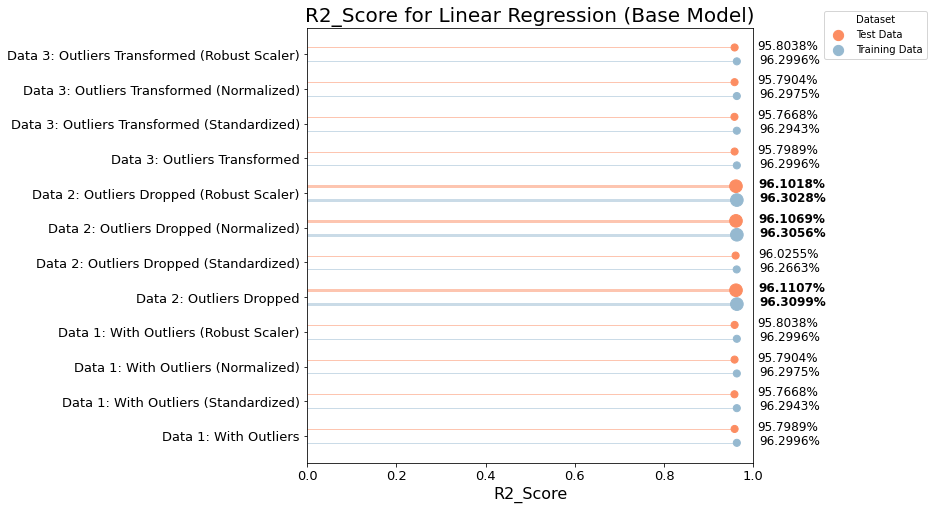

In [ ]:
PlotMetric(eval_train = linreg_eval_train, eval_test = linreg_eval_test, metric = "R2_Score", idx = idx, top_result = 3, 
           model_title = "Linear Regression (Base Model)", figsize = [8, 8], legend_coor =(1.4, 1.05), float_limit = 4)

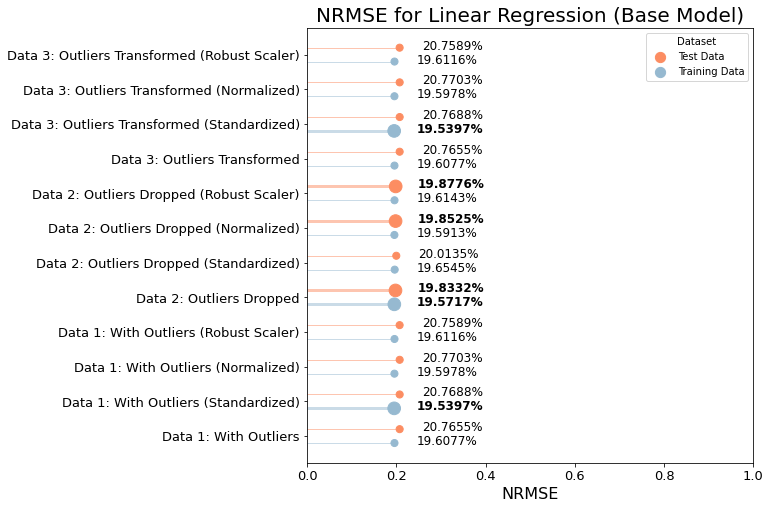

In [ ]:
PlotMetric(eval_train = linreg_eval_train, eval_test = linreg_eval_test, metric = "NRMSE", idx = idx, top_result = 3, 
           model_title = "Linear Regression (Base Model)", figsize = [8, 8], legend_coor =(1, 1), float_limit = 4)

Based on the evaluation results, we can conclude that the dataset with the best *performance* from both the R2 Score and the NRMSE is the second dataset in which all outliers have been dropped. Therefore we will use the 2nd dataset for the next modeling process.

### 3.3.2 Ridge Regression

#### 3.3.2.1 Ridge Regression: Base Model

In [ ]:
RidgeReg = Ridge()

# Dataset 2
RidgeReg.fit(X_train_2, y_train_2)
ridreg_pred      = PredictData(RidgeReg, X_train_2, X_test_2) # Predict the test set and train set

# Dataset 2 Standardized
RidgeReg.fit(data_std_2["X_train"], data_std_2["y_train"]) 
ridreg_std_pred  = PredictData(RidgeReg, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
RidgeReg.fit(data_norm_2["X_train"], data_norm_2["y_train"]) 
ridreg_norm_pred = PredictData(RidgeReg, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
RidgeReg.fit(data_robs_2["X_train"], data_robs_2["y_train"]) 
ridreg_robs_pred = PredictData(RidgeReg, data_robs_2["X_train"], data_robs_2["X_test"])

In [ ]:
# Store evaluation result for both training and testing dataset
ridreg_train = StoreEvaluationResult(y_train_2, ridreg_pred["y_train"],
                                     data_std_2["y_train"], ridreg_std_pred["y_train"],
                                     data_norm_2["y_train"], ridreg_norm_pred["y_train"],
                                     data_robs_2["y_train"], ridreg_robs_pred["y_train"])
ridreg_test  = StoreEvaluationResult(y_test_2, ridreg_pred["y_test"],
                                     data_std_2["y_test"], ridreg_std_pred["y_test"],
                                     data_norm_2["y_test"], ridreg_norm_pred["y_test"],
                                     data_robs_2["y_test"], ridreg_robs_pred["y_test"])

In [ ]:
# Evaluation Result for Training Data
new_idx                 = ["Data", "Data (Standardized)", "Data (Normalized)", "Data (Robust Scaler)"]
ridreg_eval_train       = pd.DataFrame.from_dict([ridreg_train["raw"], ridreg_train["std"], ridreg_train["norm"], ridreg_train["robs"],])
ridreg_eval_train.index = new_idx
print(f'{"RIDGE REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
ridreg_eval_train

                                 RIDGE REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,68830.870565,1.205507e+10,109795.591684,7.988987e-02,0.198493,0.962938
Data (Standardized),0.121827,3.689868e-02,0.192090,5.207467e-01,0.195787,0.963101
Data (Normalized),0.019350,9.529369e-04,0.030870,3.674020e+10,0.198492,0.962939
Data (Robust Scaler),0.078707,1.576257e-02,0.125549,1.622797e+00,0.198493,0.962938


In [ ]:
# Evaluation Result for Data Testing
ridreg_eval_test        = pd.DataFrame.from_dict([ridreg_test["raw"], ridreg_test["std"], ridreg_test["norm"], ridreg_test["robs"]])
ridreg_eval_test.index  = new_idx
print(f'{"RIDGE REGRESSION (BASE MODEL) - TEST DATA EVALUATION":^120s}')
ridreg_eval_test

                                  RIDGE REGRESSION (BASE MODEL) - TEST DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,72279.670162,1.267441e+10,112580.685059,0.083882,0.200359,0.961270
Data (Standardized),0.128318,3.911594e-02,0.197777,0.647538,0.198370,0.961121
Data (Normalized),0.020319,1.001861e-03,0.031652,0.180264,0.200352,0.961272
Data (Robust Scaler),0.082650,1.657240e-02,0.128734,0.590751,0.200359,0.961270


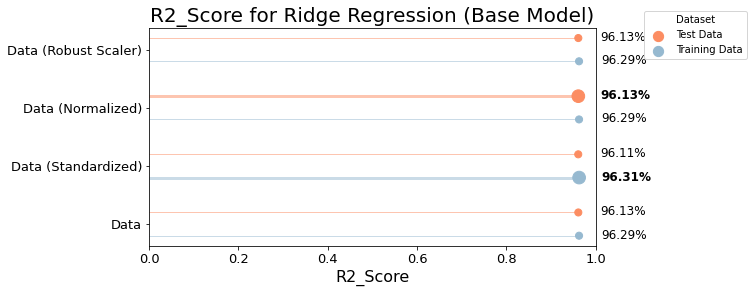

In [ ]:
PlotMetric(eval_train = ridreg_eval_train, eval_test = ridreg_eval_test, metric = "R2_Score", idx = new_idx, top_result = 1, 
           model_title = "Ridge Regression (Base Model)", figsize = [8, 4], legend_coor =(1.35, 1.1), float_limit = 2)

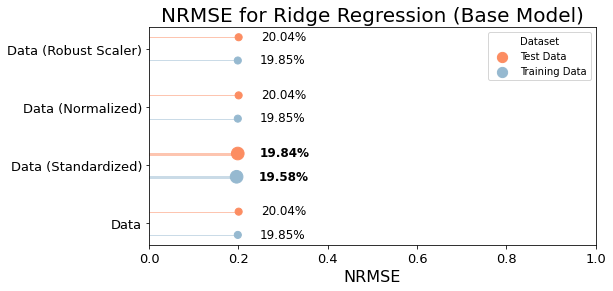

In [ ]:
PlotMetric(eval_train = ridreg_eval_train, eval_test = ridreg_eval_test, metric = "NRMSE", idx = new_idx, top_result = 1, 
          model_title = "Ridge Regression (Base Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 2)

#### 3.3.2.2 Ridge Regression: Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning (alpha values)
params      = {"alpha": (np.logspace(-8, 8, 100))} # It will check from 1e-8 to 1e+8
ridge       = Ridge()
cv          = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
ridge_model = GridSearchCV(ridge, params, cv = cv)

data_to_train = {"Data"                 : [X_train_2, y_train_2],
                 "Data (Standardized)"  : [data_std_2["X_train"], data_std_2["y_train"]],
                 "Data (Normalized)"    : [data_norm_2["X_train"], data_norm_2["y_train"]],
                 "Data (Robust Scaler)" : [data_robs_2["X_train"], data_robs_2["y_train"]]}

for idx, (data, data_values) in enumerate(data_to_train.items()):
    ridge_model.fit(data_values[0], data_values[1])
    print("{} \nBest Param: {}, Best Score Result: {}".format(data, ridge_model.best_params_, ridge_model.best_score_))

Data 
Best Param: {'alpha': 0.12915496650148853}, Best Score Result: 0.9607318206157781
Data (Standardized) 
Best Param: {'alpha': 5.336699231206324}, Best Score Result: 0.9607328438856595
Data (Normalized) 
Best Param: {'alpha': 0.12915496650148853}, Best Score Result: 0.9607320998010146
Data (Robust Scaler) 
Best Param: {'alpha': 0.12915496650148853}, Best Score Result: 0.9607318251253651


Hyperparameter Tuning Result for Ridge Regression
- Data 
Best Param: {"alpha": 0.013848863713938746}, Best Score Result: 0.9618791852514523
- Data (Standardized) 
Best Param: {"alpha": 1.74752840000769}, Best Score Result: 0.9618900813762504
- Data (Normalized) 
Best Param: {"alpha": 0.0200923300256505}, Best Score Result: 0.9618809982443115
- Data (Robust Scaler) 
Best Param: {"alpha": 0.0200923300256505}, Best Score Result: 0.9618800507884051

In [ ]:
# Dataset 2 (default/no feature scaling)
RidgeRegDef             = Ridge(alpha = 0.013848863713938746)
RidgeRegDef.fit(X_train_2, y_train_2)
ridreg_pred_tuned       = PredictData(RidgeRegDef, X_train_2, X_test_2)

# Dataset 2 Standardized
RidgeRegStd             = Ridge(alpha = 1.74752840000769)
RidgeRegStd.fit(data_std_2["X_train"], data_std_2["y_train"]) 
ridreg_std_pred_tuned   = PredictData(RidgeRegStd, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
RidgeRegNorm            = Ridge(alpha = 0.0200923300256505)
RidgeRegNorm.fit(data_norm_2["X_train"], data_norm_2["y_train"]) 
ridreg_norm_pred_tuned  = PredictData(RidgeRegNorm, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
RidgeRegRobs            = Ridge(alpha = 0.0200923300256505)
RidgeRegRobs.fit(data_robs_2["X_train"], data_robs_2["y_train"]) 
ridreg_robs_pred_tuned  = PredictData(RidgeRegRobs, data_robs_2["X_train"], data_robs_2["X_test"])

In [ ]:
# Store evaluation result for both training and testing dataset
ridreg_train_tuned = StoreEvaluationResult(y_train_2, ridreg_pred_tuned["y_train"], 
                                           data_std_2["y_train"], ridreg_std_pred_tuned["y_train"], 
                                           data_norm_2["y_train"], ridreg_norm_pred_tuned["y_train"], 
                                           data_robs_2["y_train"], ridreg_robs_pred_tuned["y_train"])   
ridreg_test_tuned  = StoreEvaluationResult(y_test_2, ridreg_pred_tuned["y_test"], 
                                           data_std_2["y_test"], ridreg_std_pred_tuned["y_test"], 
                                           data_norm_2["y_test"], ridreg_norm_pred_tuned["y_test"], 
                                           data_robs_2["y_test"], ridreg_robs_pred_tuned["y_test"])     

In [ ]:
# Evaluation Result for Training Data
ridreg_eval_train_tuned       = pd.DataFrame.from_dict([ridreg_train_tuned["raw"], ridreg_train_tuned["std"], 
                                                        ridreg_train_tuned["norm"], ridreg_train_tuned["robs"]])
ridreg_eval_train_tuned.index = new_idx
print(f'{"RIDGE REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION":^120s}')
ridreg_eval_train_tuned

                                 RIDGE REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION                                 


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,69489.406616,1.200197e+10,109553.508254,8.102433e-02,0.195768,0.963101
Data (Standardized),0.121798,3.689884e-02,0.192091,5.206315e-01,0.195826,0.963101
Data (Normalized),0.019536,9.487641e-04,0.030802,3.300295e+10,0.195782,0.963101
Data (Robust Scaler),0.079453,1.569315e-02,0.125272,1.615086e+00,0.195782,0.963101


In [ ]:
# Evaluation Result for Testing Data
ridreg_eval_test_tuned       = pd.DataFrame.from_dict([ridreg_test_tuned["raw"], ridreg_test_tuned["std"], 
                                                   ridreg_test_tuned["norm"], ridreg_test_tuned["robs"]])
ridreg_eval_test_tuned.index = new_idx
print(f'{"RIDGE REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION":^120s}')
ridreg_eval_test_tuned

                                 RIDGE REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION                                 


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,73195.345536,1.272415e+10,112801.382006,0.085416,0.198357,0.961118
Data (Standardized),0.128280,3.911037e-02,0.197763,0.646574,0.198396,0.961126
Data (Normalized),0.020577,1.005798e-03,0.031714,0.185737,0.198367,0.961120
Data (Robust Scaler),0.083689,1.663654e-02,0.128983,0.593743,0.198367,0.961120


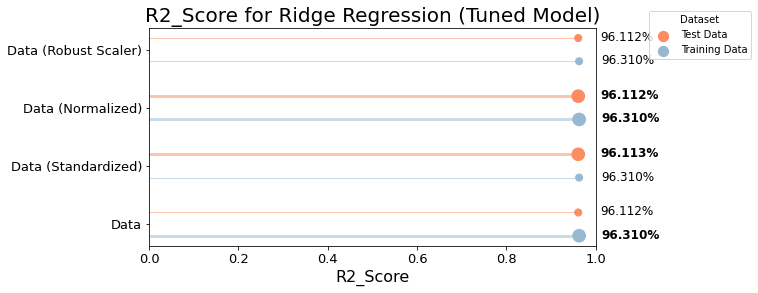

In [ ]:
PlotMetric(eval_train = ridreg_eval_train_tuned, eval_test = ridreg_eval_test_tuned, metric = "R2_Score", idx = new_idx, 
           top_result = 2, model_title = "Ridge Regression (Tuned Model)", figsize = [8, 4], legend_coor = (1.36, 1.1), float_limit = 3)

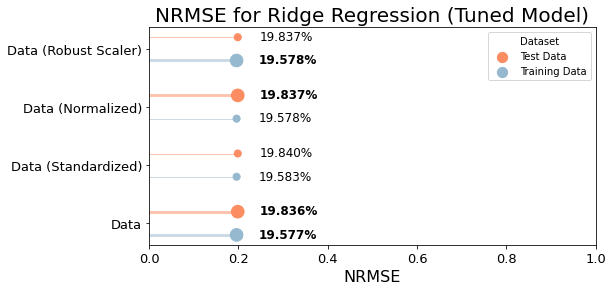

In [ ]:
PlotMetric(eval_train = ridreg_eval_train_tuned, eval_test = ridreg_eval_test_tuned, metric = "NRMSE", idx = new_idx, top_result = 2, 
           model_title = "Ridge Regression (Tuned Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 3)

### 3.3.3 Lasso Regression

#### 3.3.3.1 Lasso Regression: Base Model

In [ ]:
LassoReg         = Lasso()

# Dataset 2
LassoReg.fit(X_train_2, y_train_2)
lasreg_pred      = PredictData(LassoReg, X_train_2, X_test_2)

# Dataset 2 Standardized
LassoReg.fit(data_std_2["X_train"], data_std_2["y_train"]) 
lasreg_std_pred  = PredictData(LassoReg, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
LassoReg.fit(data_norm_2["X_train"], data_norm_2["y_train"]) 
lasreg_norm_pred = PredictData(LassoReg, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
LassoReg.fit(data_robs_2["X_train"], data_robs_2["y_train"]) 
lasreg_robs_pred = PredictData(LassoReg, data_robs_2["X_train"], data_robs_2["X_test"])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.078e+12, tolerance: 1.182e+11
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
# Store evaluation result for both training and testing dataset
lasreg_train = StoreEvaluationResult(y_train_2, lasreg_pred["y_train"], 
                                     data_std_2["y_train"], lasreg_std_pred["y_train"], 
                                     data_norm_2["y_train"], lasreg_norm_pred["y_train"], 
                                     data_robs_2["y_train"], lasreg_robs_pred["y_train"])   

lasreg_test  = StoreEvaluationResult(y_test_2, lasreg_pred["y_test"], 
                                     data_std_2["y_test"], lasreg_std_pred["y_test"], 
                                     data_norm_2["y_test"], lasreg_norm_pred["y_test"], 
                                     data_robs_2["y_test"], lasreg_robs_pred["y_test"])   

In [ ]:
# Evaluation for Training Data
lasreg_eval_train       = pd.DataFrame.from_dict([lasreg_train["raw"], lasreg_train["std"], lasreg_train["norm"], lasreg_train["robs"]])
lasreg_eval_train.index = new_idx
print(f'{"LASSO REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
lasreg_eval_train

                                 LASSO REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,69494.701095,1.200198e+10,109553.543515,8.102372e-02,1.957491e-01,0.963101
Data (Standardized),0.834135,1.000000e+00,1.000000,1.000000e+00,2.028241e+31,0.000000
Data (Normalized),0.133755,2.571269e-02,0.160352,2.939779e+11,2.888641e+15,0.000000
Data (Robust Scaler),0.543984,4.253039e-01,0.652153,4.582276e+00,2.349630e+16,0.000000


In [ ]:
# Evaluation for Data Testing
lasreg_eval_test       = pd.DataFrame.from_dict([lasreg_test["raw"], lasreg_test["std"], lasreg_test["norm"], lasreg_test["robs"]])
lasreg_eval_test.index = new_idx
print(f'{"LASSO REGRESSION (BASE MODEL) - TEST DATA EVALUATION":^120s}')
lasreg_eval_test

                                  LASSO REGRESSION (BASE MODEL) - TEST DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,73200.542119,1.272501e+10,112805.206124,0.085418,1.983447e-01,0.961115
Data (Standardized),0.839744,1.006154e+00,1.003072,1.000000,4.068945e+31,-0.000065
Data (Normalized),0.134654,2.587092e-02,0.160844,1.868536,2.897515e+15,-0.000065
Data (Robust Scaler),0.547642,4.279213e-01,0.654157,1.900083,4.713697e+16,-0.000065


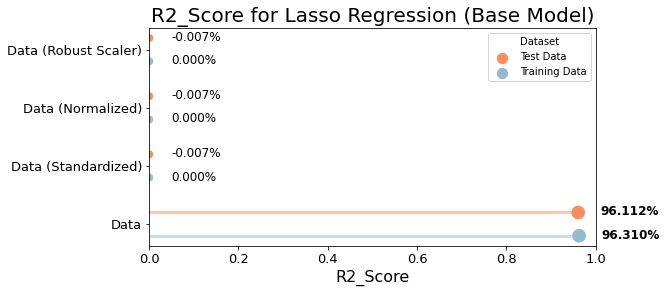

In [ ]:
PlotMetric(eval_train = lasreg_eval_train, eval_test = lasreg_eval_test, metric = "R2_Score", idx = new_idx, top_result = 1, 
           model_title = "Lasso Regression (Base Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 3)

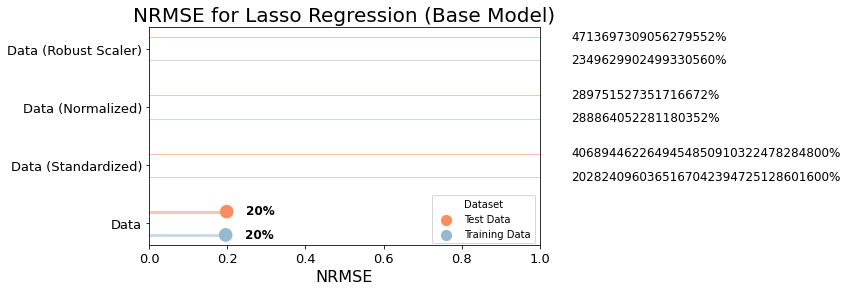

In [ ]:
PlotMetric(eval_train = lasreg_eval_train, eval_test = lasreg_eval_test, metric = "NRMSE", idx =  new_idx, top_result = 1, 
          model_title = "Lasso Regression (Base Model)", figsize = [7, 4], legend_coor =(1, 0.25), float_limit = 0)

#### 3.3.3.2 Lasso Regression: Hyperparameter Tuning

In [ ]:
params      = {"alpha": (np.logspace(-10, 10, 100))} # It will check from 1e-10 to 1e+10
lasso       = Lasso(tol = 0.05) # tolerance for stopping criteria, default is 1e-4, set it higher so model can converge
cv          = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
lasso_model = GridSearchCV(lasso, params, cv = cv)

data_to_train = {"Data"                 : [X_train_2, y_train_2],
                 "Data (Standardized)"  : [data_std_2["X_train"], data_std_2["y_train"]],
                 "Data (Normalized)"    : [data_norm_2["X_train"], data_norm_2["y_train"]],
                 "Data (Robust Scaler)" : [data_robs_2["X_train"], data_robs_2["y_train"]]}

for idx, (data, data_values) in enumerate(data_to_train.items()):
    lasso_model.fit(data_values[0], data_values[1])
    print("{} \nBest Param: {}, Best Score Result: {}".format(data, lasso_model.best_params_, lasso_model.best_score_))

Data 
Best Param: {'alpha': 8.111308307896856}, Best Score Result: 0.9598862710875953
Data (Standardized) 
Best Param: {'alpha': 0.0004641588833612782}, Best Score Result: 0.9602588803968932
Data (Normalized) 
Best Param: {'alpha': 4.430621457583877e-06}, Best Score Result: 0.9598908752907214
Data (Robust Scaler) 
Best Param: {'alpha': 1.1233240329780266e-05}, Best Score Result: 0.9598867622718598


Hyperparameter Tuning Result
- Data 
Best Param: {"alpha": 533.6699231206302}, Best Score Result: 0.9553662473042566
- Data (Standardized) 
Best Param: {"alpha": 1e-10}, Best Score Result: 0.9522732729417466
- Data (Normalized) 
Best Param: {"alpha": 0.0001830738280295366}, Best Score Result: 0.9459517056655325
- Data (Robust Scaler) 
Best Param: {"alpha": 0.0007390722033525775}, Best Score Result: 0.9484703356860236

In [ ]:
# Dataset 2 
LassoRegDef             = Lasso(alpha = 533.6699231206302, tol = 0.05)
LassoRegDef.fit(X_train_2, y_train_2)
lasreg_pred_tuned       = PredictData(LassoRegDef, X_train_2, X_test_2)

# Dataset 2 Standardized
LassoRegStd             = Lasso(alpha = 1e-10, tol = 0.05)
LassoRegStd.fit(data_std_2["X_train"], data_std_2["y_train"]) 
lasreg_std_pred_tuned   = PredictData(LassoRegStd, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
LassoRegNorm            = Lasso(alpha =  0.0001830738280295366, tol = 0.05)
LassoRegNorm.fit(data_norm_2["X_train"], data_norm_2["y_train"]) 
lasreg_norm_pred_tuned  = PredictData(LassoRegNorm, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
LassoRegRobs            = Lasso(alpha = 0.0007390722033525775, tol = 0.05)
LassoRegRobs.fit(data_robs_2["X_train"], data_robs_2["y_train"]) 
lasreg_robs_pred_tuned  = PredictData(LassoRegRobs, data_robs_2["X_train"], data_robs_2["X_test"])

In [ ]:
# Store evaluation result for both training and testing dataset
lasreg_train_tuned  = StoreEvaluationResult(y_train_2, lasreg_pred_tuned["y_train"], 
                                            data_std_2["y_train"], lasreg_std_pred_tuned["y_train"], 
                                            data_norm_2["y_train"], lasreg_norm_pred_tuned["y_train"], 
                                            data_robs_2["y_train"], lasreg_robs_pred_tuned["y_train"])   

lasreg_test_tuned   = StoreEvaluationResult(y_test_2, lasreg_pred_tuned["y_test"], 
                                            data_std_2["y_test"], lasreg_std_pred_tuned["y_test"], 
                                            data_norm_2["y_test"], lasreg_norm_pred_tuned["y_test"], 
                                            data_robs_2["y_test"], lasreg_robs_pred_tuned["y_test"])   

In [ ]:
# Evaluation for Training Data
lasreg_eval_train_tuned       = pd.DataFrame.from_dict([lasreg_train_tuned["raw"], lasreg_train_tuned["std"], 
                                                        lasreg_train_tuned["norm"], lasreg_train_tuned["robs"]])
lasreg_eval_train_tuned.index = new_idx
print(f'{"LASSO REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION":^120s}')
lasreg_eval_train_tuned

                                 LASSO REGRESSION (TUNED MODEL) - TRAIN DATA EVALUATION                                 


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,73289.662584,1.343318e+10,115901.595485,8.314821e-02,0.215127,0.958701
Data (Standardized),0.123436,3.737617e-02,0.193329,5.218807e-01,0.196926,0.962624
Data (Normalized),0.020927,1.096039e-03,0.033106,5.572572e+10,0.220482,0.957374
Data (Robust Scaler),0.085423,1.817375e-02,0.134810,8.203423e-01,0.220636,0.957269


In [ ]:
# Evaluation for Testing  Data
lasreg_eval_test_tuned       = pd.DataFrame.from_dict([lasreg_test_tuned["raw"], lasreg_test_tuned["std"], 
                                                       lasreg_test_tuned["norm"], lasreg_test_tuned["robs"]])
lasreg_eval_test_tuned.index = new_idx
print(f'{"LASSO REGRESSION (TUNED MODEL) - TEST DATA EVALUATION":^120s}')
lasreg_eval_test_tuned

                                 LASSO REGRESSION (TUNED MODEL) - TEST DATA EVALUATION                                  


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,75495.700488,1.373566e+10,117199.212243,0.085216,0.214080,0.958027
Data (Standardized),0.130213,3.976212e-02,0.199404,0.590080,0.200010,0.960479
Data (Normalized),0.021511,1.111946e-03,0.033346,0.178056,0.218501,0.957017
Data (Robust Scaler),0.087845,1.845100e-02,0.135834,0.528795,0.218750,0.956879


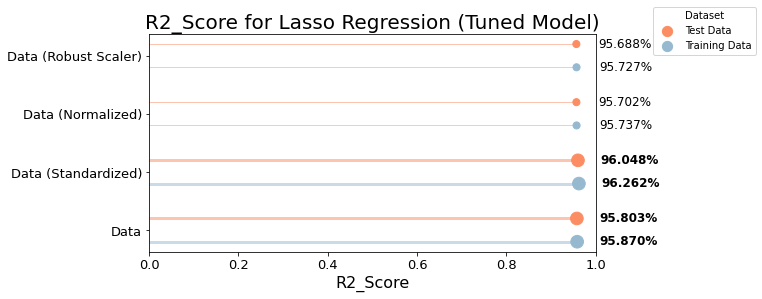

In [ ]:
PlotMetric(eval_train = lasreg_eval_train_tuned, eval_test =  lasreg_eval_test_tuned, metric = "R2_Score", idx = new_idx, 
           top_result = 2, model_title = "Lasso Regression (Tuned Model)", figsize = [8, 4], legend_coor =(1.37, 1.15), float_limit = 3)

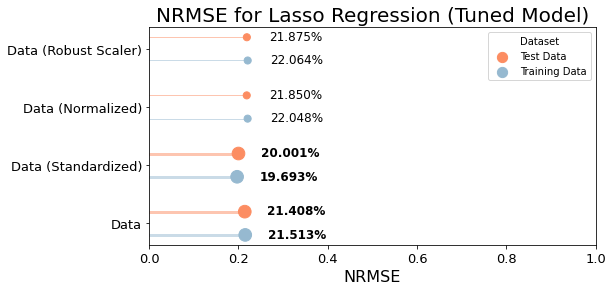

In [ ]:
PlotMetric(eval_train = lasreg_eval_train_tuned, eval_test = lasreg_eval_test_tuned, metric = "NRMSE", idx =  new_idx, top_result = 2, 
           model_title = "Lasso Regression (Tuned Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 3)

**Analysis**

The base model from Lasso has a pretty bad *performance*. The dataset that we process has many *categorical predictors* such as Store, Holiday_Flag, Month, Week, WeekOfYear, Day, and others. Based on the *feature importance* results obtained from the regressor coefficients, in this dataset *numerical predictor* actually has a very low *importance* value compared to *categorical predictor*.

ScikitLearn's Lasso algorithm doesn't seem to be able to handle this problem because Lasso gives a *penalty* value to features that have a minor contribution so that the coefficient is close to/to zero [[1]](http://www.sthda.com/english/articles/37 -model-selection-essentials-in-r/153-penalized-regression-essentials-ridge-lasso-elastic-net/#:~:text=In%20the%20case%20of%20lasso,be%20exactly%20equal%20to %20zero.), while the encoded *categorical predictor* will split into several variables (Example: "Store" feature will be "Store_1", "Store_2", .... "Store N") and not enter it makes sense to take only some of the variables from the *categorical predictor*. For example, after knowing the value of the coefficients, "Store_27" and "Store_31" are not penalized for having a larger contribution, but "Store _44" has such a small contribution that Lasso penalizes them by making the coefficients 0, whereas they cannot because they are one. unity and should all the features that have been encoded from the "Store" feature taken all or not all used) so a special *treatment* (lasso modification) is needed for this kind of problem. [[2]](https://stats.stackexchange.com/questions/209009/how-to-treat-categorical-predictors-in-lasso) [[3]](https://stats.stackexchange.com/ questions/548958/why-are-my-elastic-net-and-lasso-r-squared-measures-negative). Meanwhile, the reason why Lasso has good *performance* on datasets without *feature scaling* we have not found because based on existing sources Lasso should have good *performance* if the data scale is the same [[4]](https://stats stackexchange.com/questions/86434/is-standardisation-before-lasso-really-necessary).

Meanwhile, after hyperpameter tuning, with an alpha close to 0, the *performance* of the model immediately increases because the smaller the alpha, the smaller the penalty given by Lasso. Based on the documentation from Scikit Learn [[5]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), if the alpha value is set close to or equal to zero, then the method Lasso's work is essentially the same as standard Linear Regression because the penalty effects are almost non-existent. Therefore, when tuning with alpha is close to 0, the *performance* of the model, both the R2 score and the NRMSE, changes drastically.

### 3.3.4 ElasticNet Regression

#### 3.3.4.1 ElasticNet Regression: Base Model

In [ ]:
ENetReg = ElasticNet()

# Dataset 2
ENetReg.fit(X_train_2, y_train_2)
enetreg_pred      = PredictData(ENetReg, X_train_2, X_test_2)

# Dataset 2 Standardized
ENetReg.fit(data_std_2["X_train"], data_std_2["y_train"]) 
enetreg_std_pred  = PredictData(ENetReg, data_std_2["X_train"], data_std_2["X_test"])

# Dataset 2 Normalized
ENetReg.fit(data_norm_2["X_train"], data_norm_2["y_train"]) 
enetreg_norm_pred = PredictData(ENetReg, data_norm_2["X_train"], data_norm_2["X_test"])

# Dataset 2 Robust Scaler
ENetReg.fit(data_robs_2["X_train"], data_robs_2["y_train"]) 
enetreg_robs_pred = PredictData(ENetReg, data_robs_2["X_train"], data_robs_2["X_test"])

In [ ]:
# Store evaluation result for both training and testing dataset
enetreg_train = StoreEvaluationResult(y_train_2, enetreg_pred["y_train"], 
                                      data_std_2["y_train"], enetreg_std_pred["y_train"], 
                                      data_norm_2["y_train"], enetreg_norm_pred["y_train"], 
                                      data_robs_2["y_train"], enetreg_robs_pred["y_train"])   

enetreg_test  = StoreEvaluationResult(y_test_2, enetreg_pred["y_test"], 
                                      data_std_2["y_test"], enetreg_std_pred["y_test"], 
                                      data_norm_2["y_test"], enetreg_norm_pred["y_test"], 
                                      data_robs_2["y_test"], enetreg_robs_pred["y_test"])   

In [ ]:
# Evaluation for Training Data
enetreg_eval_train       = pd.DataFrame.from_dict([enetreg_train["raw"], enetreg_train["std"], enetreg_train["norm"], enetreg_train["robs"]])
enetreg_eval_train.index = new_idx
print(f'{"ELASTICNET REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION":^120s}')
enetreg_eval_train

                               ELASTICNET REGRESSION (BASE MODEL) - TRAIN DATA EVALUATION                               


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,451800.274415,2.925551e+11,540883.629244,6.264255e-01,1.049181e+01,0.100574
Data (Standardized),0.834135,1.000000e+00,1.000000,1.000000e+00,2.028241e+31,0.000000
Data (Normalized),0.133755,2.571269e-02,0.160352,2.939779e+11,2.888641e+15,0.000000
Data (Robust Scaler),0.543984,4.253039e-01,0.652153,4.582276e+00,2.349630e+16,0.000000


In [ ]:
# Evaluation for Data Testing
enetreg_eval_test       = pd.DataFrame.from_dict([enetreg_test["raw"], enetreg_test["std"], enetreg_test["norm"], enetreg_test["robs"]])
enetreg_eval_test.index = new_idx
print(f'{"ELASTICNET REGRESSION (BASE MODEL)- TEST DATA EVALUATION":^120s}')
enetreg_eval_test

                                ELASTICNET REGRESSION (BASE MODEL)- TEST DATA EVALUATION                                


,MAE,MSE,RMSE,MAPE,NRMSE,R2_Score
Data,454893.176455,2.946933e+11,542856.581575,0.648914,1.047247e+01,0.099483
Data (Standardized),0.839744,1.006154e+00,1.003072,1.000000,4.068945e+31,-0.000065
Data (Normalized),0.134654,2.587092e-02,0.160844,1.868536,2.897515e+15,-0.000065
Data (Robust Scaler),0.547642,4.279213e-01,0.654157,1.900083,4.713697e+16,-0.000065


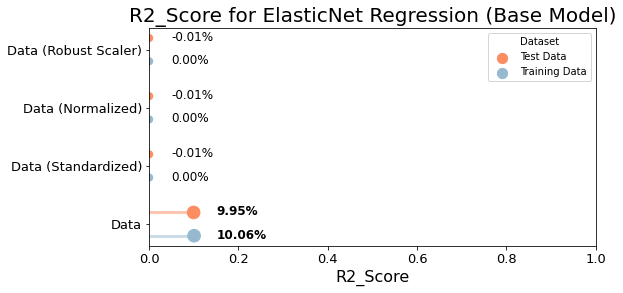

In [ ]:
PlotMetric(eval_train = enetreg_eval_train, eval_test = enetreg_eval_test,  metric ="R2_Score", idx = new_idx, top_result = 1, 
           model_title = "ElasticNet Regression (Base Model)", figsize = [8, 4], legend_coor =(1, 1), float_limit = 2)

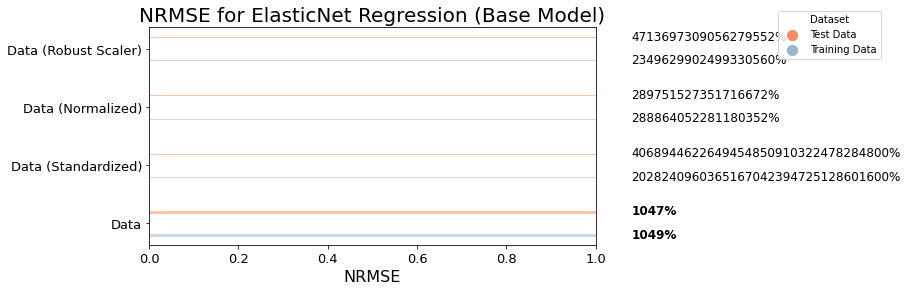

In [ ]:
PlotMetric(eval_train = enetreg_eval_train, eval_test = enetreg_eval_test, metric = "NRMSE", idx = new_idx, top_result = 1, 
           model_title = "ElasticNet Regression (Base Model)", figsize = [8, 4], legend_coor =(1.65, 1.1), float_limit = 0)

The results of the ElasticNet model are very poor, both from the R2 Score and the NRMSE value. According to our assumption, this is because ElasticNet is a combination of Ridge and Lasso. Meanwhile, as we can see in the previous stage, Lasso's performance on this data is also arguably poor and only improves when its alpha is set to near zero (which means the same as using standard Linear Regression). Detailed explanation of Lasso is in the previous stage.